In [1]:
import zipfile

# Path to your zip file and target directory
zip_file_path = 'archive.zip'
extract_to = '/content/Soil-classification-dataset'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)


In [2]:
print(extract_to)

/content/Soil-classification-dataset


Filtered dataset created at: /content/Soil_classification_sampled
Found 4032 images belonging to 3 classes.
Found 1008 images belonging to 3 classes.
Epoch 1/10
126/126 [==============================] - 970s 8s/step - loss: 0.3681 - accuracy: 0.8517 - val_loss: 0.1750 - val_accuracy: 0.9266
Epoch 2/10
126/126 [==============================] - 640s 5s/step - loss: 0.1866 - accuracy: 0.9328 - val_loss: 0.1173 - val_accuracy: 0.9514
Epoch 3/10
126/126 [==============================] - 650s 5s/step - loss: 0.1406 - accuracy: 0.9472 - val_loss: 0.1233 - val_accuracy: 0.9554
Epoch 4/10
126/126 [==============================] - 679s 5s/step - loss: 0.1295 - accuracy: 0.9514 - val_loss: 0.0758 - val_accuracy: 0.9742
Epoch 5/10
126/126 [==============================] - 1114s 9s/step - loss: 0.1185 - accuracy: 0.9529 - val_loss: 0.1454 - val_accuracy: 0.9415
Epoch 6/10
126/126 [==============================] - 884s 7s/step - loss: 0.1225 - accuracy: 0.9541 - val_loss: 0.0840 - val_accuracy

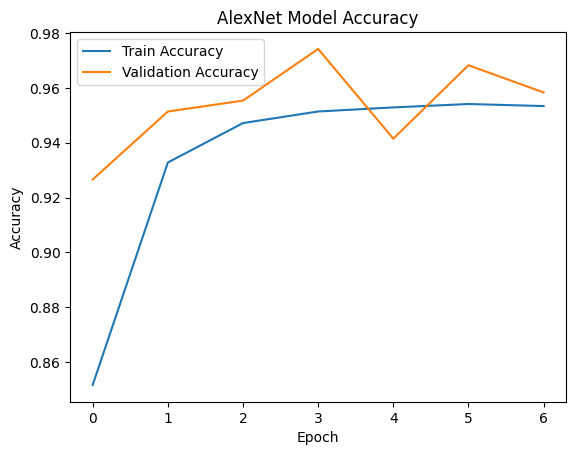

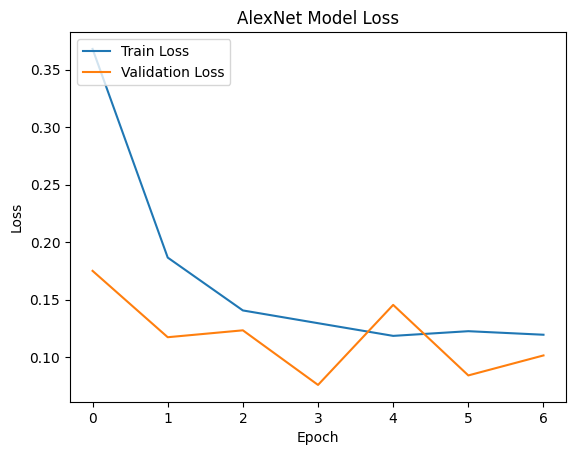

32/32 [==============================] - 129s 3s/step


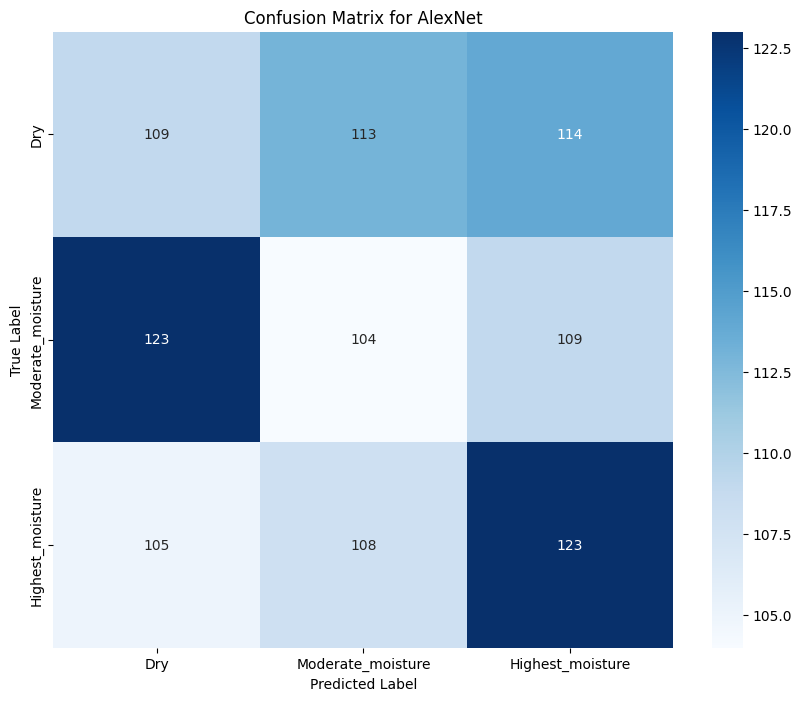

Classification Report for AlexNet:
                   precision    recall  f1-score   support

              Dry       0.32      0.32      0.32       336
Moderate_moisture       0.32      0.31      0.31       336
 Highest_moisture       0.36      0.37      0.36       336

         accuracy                           0.33      1008
        macro avg       0.33      0.33      0.33      1008
     weighted avg       0.33      0.33      0.33      1008



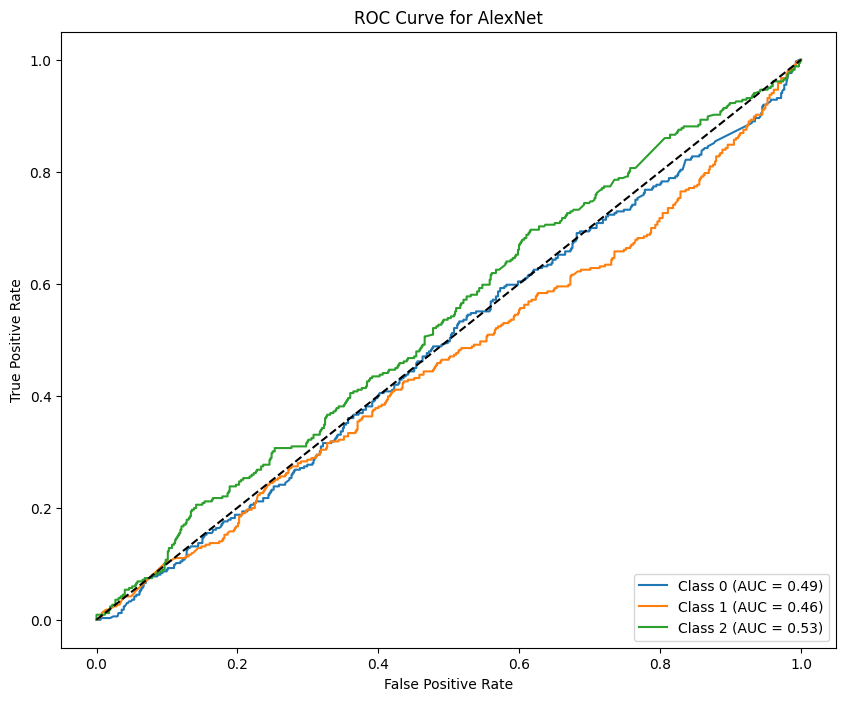

In [1]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import tensorflow as tf


seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
# Define paths and parameters
dataset_path = '/content/Soil-classification-dataset/NASA_Soil_Moisture_India_Dataset/Soil_classification_dataset'
temp_dataset_path = '/content/Soil_classification_sampled'  # Temporary directory for 3 classes
image_size = (96, 96)  # Match the input shape for AlexNet and VGG16
batch_size = 32
validation_split = 0.2
num_classes = 3
samples_per_class = 1680  # Adjust this as needed
wanted_classes = ['Dry', 'Moderate_moisture', 'Highest_moisture']  # Classes to include

# Clean and prepare temporary directory
if os.path.exists(temp_dataset_path):
    shutil.rmtree(temp_dataset_path)
os.makedirs(temp_dataset_path)

# Randomly sample images for each class
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir) and class_name in wanted_classes:
        temp_class_dir = os.path.join(temp_dataset_path, class_name)
        os.makedirs(temp_class_dir, exist_ok=True)
        images = os.listdir(class_dir)
        selected_images = random.sample(images, min(samples_per_class, len(images)))
        for img in selected_images:
            shutil.copy(os.path.join(class_dir, img), temp_class_dir)
print(f"Filtered dataset created at: {temp_dataset_path}")

# Data generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=validation_split
    
)

train_generator = datagen.flow_from_directory(
    temp_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use categorical for one-hot encoded labels
    subset='training',
     seed=seed_value
)

validation_generator = datagen.flow_from_directory(
    temp_dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use categorical for one-hot encoded labels
    subset='validation',
    seed=seed_value
)

# AlexNet-like architecture using VGG16
def alexnet(input_shape=(96, 96, 3), num_classes=3):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
# Build and train AlexNet model
alexnet_model = alexnet(input_shape=(96, 96, 3), num_classes=num_classes)
history_alexnet = alexnet_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

# Evaluate AlexNet model
val_loss, val_accuracy = alexnet_model.evaluate(validation_generator)
print(f"AlexNet Validation accuracy: {val_accuracy * 100:.2f}%")

# Plot AlexNet training history
plt.plot(history_alexnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('AlexNet Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

plt.plot(history_alexnet.history['loss'], label='Train Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.title('AlexNet Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

# Confusion Matrix
y_true = validation_generator.classes
y_pred = alexnet_model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=wanted_classes, yticklabels=wanted_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for AlexNet')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=wanted_classes)
print("Classification Report for AlexNet:")
print(report)

# ROC Curve
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for AlexNet')
plt.legend(loc='lower right')
plt.show()